# Predicting Solar Panel Adoption - Hyperparameter Tuning for Classifier
#### UC Berkeley MIDS
`Team: Gabriel Hudson, Noah Levy, Laura Williams`

Hypertuning can easily lead to over-fitting to training data.  This notebook uses our final full dataset and tests 3 hyperparameters separately, simultaneously testing for overfitting by comparing predictions from the training data vs. the test data for each hpyerparameter setting.

**Summary**   
Optimal random forest classifier hyperparameter values for final dataset with 58 features are:  
`max_depth=25`  
`max_features=0.25`  
`n-estimators=150` 

In [1]:
# imports
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn import metrics

%matplotlib inline

In [2]:
# load curated dataset
deepsolar = pd.read_csv('../Datasets/SolarPrediction_Final_Dataset.csv', index_col=0)

In [3]:
print("Dataset rows and dimensions:", deepsolar.shape)

Dataset rows and dimensions: (71305, 59)


## Define outcome variable

In [4]:
# create binary outcome variable for stage 1 RF classifier
deepsolar['solar_flag']=deepsolar['owner_occupied_solar_system_density'].apply(lambda x: int(x>0))
outcome_var = 'solar_flag'

In [5]:
# remove outcome variable used only for Stage 2 RF regressor
deepsolar.drop(labels=['owner_occupied_solar_system_density'], axis=1, inplace=True)
deepsolar.shape

(71305, 59)

## For testing only:  create sample data for testing implementation

In [118]:
deepsolar_sample = deepsolar.sample(frac=.10)
print("Small sample dataset rows and dimensions:", deepsolar_sample.shape)

Small sample dataset rows and dimensions: (24957, 59)


In [119]:
X_sample = deepsolar_sample.drop(labels=[outcome_var], axis=1).values
Y_sample = deepsolar_sample[outcome_var].values
print("Sample data featureset shape is", X_sample.shape)
print("Sample data regressor outcome variable shape:", Y_sample.shape)

Sample data featureset shape is (24957, 58)
Sample data regressor outcome variable shape: (24957, 58)


## Split outcome variable from features in full dataset

In [8]:
X = deepsolar.drop(labels=[outcome_var], axis=1).values
Y = deepsolar[outcome_var].values
print("Full featureset shape is", X.shape)
print("Outcome variable shape:", Y.shape)

Full featureset shape is (71305, 58)
Outcome variable shape: (71305,)


## Define functions for hyperparameter tuning

In [95]:
def TrainRF(X_train, Y_train, X_test, n, depth, features):
    """Train a random forest classifier.
    
    Input: single training and test dataset and test outcome variable dataset, 
    random forest hyperparameters:
    n (the number of random decision trees to create),
    max_depth (the depth of the tree), and 
    max_features (the subset of features the model randomly selects).  
    Output: model and predictions on both the training data and the test data
    """
    RF = RandomForestClassifier(n_estimators=n, max_depth=depth, max_features=features, n_jobs=-1)
    RF.fit(X_train, Y_train)
    preds_test = RF.predict_proba(X_test)
    preds_train = RF.predict_proba(X_train)
    
    return RF, preds_test, preds_train  

In [96]:
def create_splits(X, Y, n_splits):
    """Create dataset splits for cross-validated hyperparameter tuning.
    
    Input: full dataset, split into features(X) and outcome variable(Y), number of splits.
    Output: train and test set as lists of splits
    """
    # set up splits
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=None)
    # initialize variables
    X_trains=[]
    X_tests=[]
    Y_trains=[]
    Y_tests=[]
    # create lists of data splits
    for train_index, test_index in kf.split(X):
        X_trains.append(X[train_index])
        X_tests.append(X[test_index])
        Y_trains.append(Y[train_index])
        Y_tests.append(Y[test_index])
    return X_trains, X_tests, Y_trains, Y_tests

In [97]:
def run_max_depth_test_CV(X, Y, n_splits, iterations, n, depth_values, features):
    """Creates cross-validated dataset, tests hyperparameter options and returns all scores.
    
    Input: single dataset of features and outcome variable, 
    number of splits for cross-validation,
    number of iterations,
    hyperparameter values to test.
    Output: scores from the function for all cross-validated splits of the dataset.
    """
    
    def find_max_depth(X_train, Y_train, X_test, Y_test, n, depth_values, features):
        """Helper function:
        Find optimal value of max_depth in a random forest model.  

        Input: single training, test and outcome variable dataset, 
        single hyperparameter values for n-estimators and max_features,
        list of hyperparameter values for max_depth
        Output: r squared and log loss scores on both training and test data
        """
        r2_scores = []
        log_losses_train = []
        log_losses_test = []
        for depth in depth_values:     
            # train model
            RF, preds_test, preds_train = TrainRF(X_train, Y_train, X_test, n, depth, features)
            #calculate R squared on test data
            r2_score = RF.score(X_test,Y_test)
            r2_scores.append(r2_score)
            # calculate log loss on test data AND training data
            log_train = metrics.log_loss(Y_train, preds_train)
            log_losses_train.append(log_train)
            log_test = metrics.log_loss(Y_test, preds_test)
            log_losses_test.append(log_test)

        return r2_scores, log_losses_train, log_losses_test

    # create dataset splits
    X_trains, X_tests, Y_trains, Y_tests = create_splits(X, Y, n_splits)
    # initialize arrays to hold results
    all_depths = np.zeros((n_splits*iterations, (len(depth_values))))
    all_r2_scores = np.zeros((n_splits*iterations, (len(depth_values))))
    all_log_losses_train = np.zeros((n_splits*iterations, (len(depth_values))))
    all_log_losses_test = np.zeros((n_splits*iterations, (len(depth_values))))
    # run hyperparameter testing using helper function
    for i in range(iterations):
        for j in range(n_splits):
            r2_scores, log_losses_train, log_losses_test = find_max_depth(X_trains[j], Y_trains[j], 
                                                                          X_tests[j], Y_tests[j], 
                                                                          n, depth_values, features)
            index = (i*n_splits) + j
            all_depths[index] = depth_values
            all_r2_scores[index] = r2_scores
            all_log_losses_train[index] = log_losses_train
            all_log_losses_test[index] = log_losses_test
            print("Finished iteration", i+1, "and data split", j+1)
        
    return all_depths, all_r2_scores, all_log_losses_train, all_log_losses_test

In [98]:
def run_max_features_test_CV(X, Y, n_splits, iterations, n, depth, num_features):
    """Creates cross-validated dataset, tests hyperparameter options and returns all scores.
    
    Input: single dataset of features and outcome variable, 
    number of splits for cross-validation,
    number of iterations,
    hyperparameter values to test.
    Output: scores from the function for all cross-validated splits of the dataset.
    """
    
    def find_max_features(X_train, Y_train, X_test, Y_test, n, depth, num_features):
        """Helper function:
        Find optimal value of max_features in a random forest model.  

        Input: single training, test and outcome variable dataset, 
        single hyperparameter values for n-estimators and max_depth
        list of hyperparameter values for max_features
        Output: r squared and log loss scores on both training and test data  
        """
        r2_scores = []
        log_losses_train = []
        log_losses_test = []
        for f in num_features:    
            # train model
            RF, preds_test, preds_train = TrainRF(X_train, Y_train, X_test, n, depth, f)
            #calculate R squared on test data
            r2_score = RF.score(X_test,Y_test)
            r2_scores.append(r2_score)
            # calculate log loss on test data AND training data
            log_train = metrics.log_loss(Y_train, preds_train)
            log_losses_train.append(log_train)
            log_test = metrics.log_loss(Y_test, preds_test)
            log_losses_test.append(log_test)

        return r2_scores, log_losses_train, log_losses_test

    # create dataset splits
    X_trains, X_tests, Y_trains, Y_tests = create_splits(X, Y, n_splits)
    # initialize arrays to hold results
    all_num_features = np.zeros((n_splits*iterations, (len(num_features))))
    all_r2_scores = np.zeros((n_splits*iterations, (len(num_features))))
    all_log_losses_train = np.zeros((n_splits*iterations, (len(num_features))))
    all_log_losses_test = np.zeros((n_splits*iterations, (len(num_features))))
    # run hyperparameter testing using helper function
    for i in range(iterations):
        for j in range(n_splits):
            r2_scores, log_losses_train, log_losses_test = find_max_features(X_trains[j], Y_trains[j], 
                                                                             X_tests[j], Y_tests[j], 
                                                                             n, depth, num_features)
            index = (i*n_splits) + j
            all_num_features[index] = num_features
            all_r2_scores[index] = r2_scores
            all_log_losses_train[index] = log_losses_train
            all_log_losses_test[index] = log_losses_test
            print("Finished iteration", i+1, "and data split", j+1)
        
    return all_num_features, all_r2_scores, all_log_losses_train, all_log_losses_test

In [99]:
def run_n_estimators_test_CV(X, Y, n_splits, iterations, n_values, depth, features):
    """Creates cross-validated dataset, tests hyperparameter options and returns all scores.
    
    Input: single dataset of features and outcome variable, 
    number of splits for cross-validation,
    number of iterations,
    hyperparameter values to test.
    Output: scores from the function for all cross-validated splits of the dataset.
    """
    
    def find_n(X_train, Y_train, X_test, Y_test, n_values, depth, features):
        """Find optimal value of n in a random forest model.  

        Input: single training, test and outcome variable dataset,
        single hyperparameter values for max_depth and max_features,
        list of hyperparameter values for n-estimators
        Output: r squared and log loss scores on both training and test data  
        """
        r2_scores = []
        log_losses_train = []
        log_losses_test = []
        for n in n_values:    
            # train model
            RF, preds_test, preds_train = TrainRF(X_train, Y_train, X_test, n, depth, features)
            #calculate R squared on test data 
            r2_score = RF.score(X_test,Y_test)
            r2_scores.append(r2_score)
            # calculate log loss on test data AND training data
            log_train = metrics.log_loss(Y_train, preds_train)
            log_losses_train.append(log_train)
            log_test = metrics.log_loss(Y_test, preds_test)
            log_losses_test.append(log_test)

        return r2_scores, log_losses_train, log_losses_test

    # create dataset splits
    X_trains, X_tests, Y_trains, Y_tests = create_splits(X, Y, n_splits)
    # initialize arrays to hold results
    all_n_values = np.zeros((n_splits*iterations, (len(n_values))))
    all_r2_scores = np.zeros((n_splits*iterations, (len(n_values))))
    all_log_losses_train = np.zeros((n_splits*iterations, (len(n_values))))
    all_log_losses_test = np.zeros((n_splits*iterations, (len(n_values))))
    # run hyperparameter testing using helper function
    for i in range(iterations):
        for j in range(n_splits):
            r2_scores, log_losses_train, log_losses_test = find_n(X_trains[j], Y_trains[j], 
                                                                  X_tests[j], Y_tests[j], 
                                                                  n_values, depth, features)
            index = (i*n_splits) + j
            all_n_values[index] = n_values
            all_r2_scores[index] = r2_scores
            all_log_losses_train[index] = log_losses_train
            all_log_losses_test[index] = log_losses_test
            print("Finished iteration", i+1, "and data split", j+1)
        
    return all_n_values, all_r2_scores, all_log_losses_train, all_log_losses_test

## Tune hyper-parameters on full dataset with cross-validation

To test on sample data, use the X_sample and Y_sample variables when calling functions instead of the full dataset variables, X and Y.

**Testing for overfitting**  
Generally errors on predictions on the training dataset would be expected to be less than on the test dataset. As the model improves, the ratio of errors on the training set to errors on the test set will grow smaller and may stabilize. However, if the ratio of errors of the training over test set start to increase again after growing smaller, that's an indication that the model is being overfit to the training data. In general, the smallest ratio of training set errors to test set errors is the point of least overfitting.

In [138]:
# set cross-validation splits and iterations
n_splits = 3
iterations = 2

Static values for hyperparameters in each section are determined by optimal values from independently testing those hyperparameters.

### Test `max_depth`

In [176]:
# test max_depth with CV
n = 150
depth_values = [9, 11, 13, 15, 17, 20, 25, 30, 35, 40]
features = 0.25
start = time.time()
all_depths, \
all_r2_scores_d, \
all_log_losses_train_d,  \
all_log_losses_test_d = run_max_depth_test_CV(X, Y, n_splits, iterations, n, depth_values, features)
#print("Processing time: {} seconds".format((time.time() - start)))
print("Processing time: {} minutes".format(round((time.time() - start)/60, 2)))

Finished iteration 1 and data split 1
Finished iteration 1 and data split 2
Finished iteration 1 and data split 3
Finished iteration 2 and data split 1
Finished iteration 2 and data split 2
Finished iteration 2 and data split 3
Processing time: 46.16 minutes


In [207]:
# save results to CSV
np.savetxt("../Tuning_Results/Classifier/C_depths_n150_f25.csv", all_depths, delimiter=",")
np.savetxt("../Tuning_Results/Classifier/C_depths_r2_n150_f25.csv", all_r2_scores_d, delimiter=",")
np.savetxt("../Tuning_Results/Classifier/C_depths_loglosstrain_n150_f25.csv", all_log_losses_train_d, delimiter=",")
np.savetxt("../Tuning_Results/Classifier/C_depths_loglosstest_n150_f25.csv", all_log_losses_test_d, delimiter=",")

In [209]:
# load results from CSV files (for drawing plots without re-doing tuning calculations above)
all_depths = np.loadtxt("../Tuning_Results/Classifier/C_depths_n150_f25.csv", delimiter=",")
all_r2_scores_d = np.loadtxt("../Tuning_Results/Classifier/C_depths_r2_n150_f25.csv", delimiter=",")
all_log_losses_train_d = np.loadtxt("../Tuning_Results/Classifier/C_depths_loglosstrain_n150_f25.csv", delimiter=",")
all_log_losses_test_d = np.loadtxt("../Tuning_Results/Classifier/C_depths_loglosstest_n150_f25.csv", delimiter=",")
depth_values = all_depths[0]

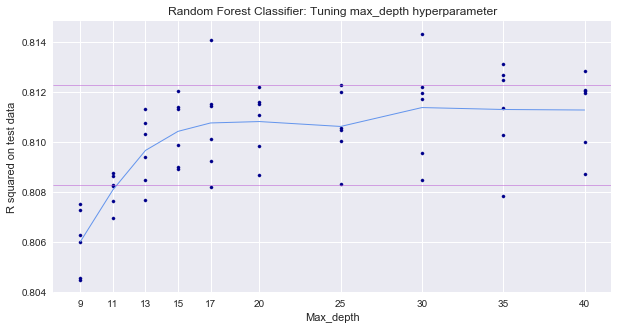

In [185]:
# Plot R squared results from max depth on training data

# Set up data for the plot
avg_r2_score_per_depth = np.mean(all_r2_scores_d, axis=0)

# Plot max_depth results
plt.figure(figsize=(10,5))
x = depth_values 
plt.xticks(x)
plt.xlabel("Max_depth")
plt.ylabel("R squared on test data")
plt.title("Random Forest Classifier: Tuning max_depth hyperparameter")
plt.plot(depth_values, avg_r2_score_per_depth, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_depths, all_r2_scores_d, c = "darkblue", s=10)
# Lines for best scores 
plt.axhline(y=0.8123, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=0.8083, linewidth=0.5, color = 'mediumorchid')
plt.show()
# plt.savefig("Images/<filename>.png")


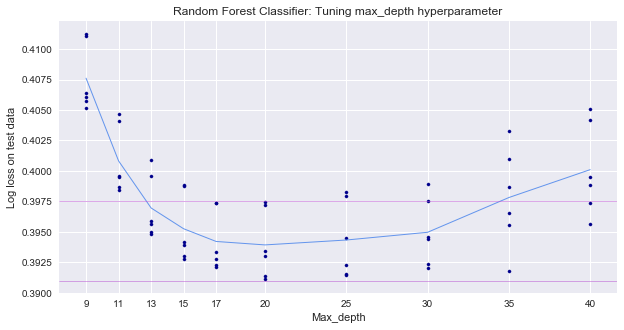

In [186]:
# Plot log loss results on training data

# Set up data for the plot
avg_log_loss_per_depth = np.mean(all_log_losses_test_d, axis=0)

# Plot max_depth results
plt.figure(figsize=(10,5))
x = depth_values 
plt.xticks(x)
plt.xlabel("Max_depth")
plt.ylabel("Log loss on test data")
plt.title("Random Forest Classifier: Tuning max_depth hyperparameter")
plt.plot(depth_values, avg_log_loss_per_depth, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_depths, all_log_losses_test_d, c = "darkblue", s=10)
# Lines for best scores 
plt.axhline(y=.39756, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=.391, linewidth=0.5, color = 'mediumorchid')
plt.show()
# plt.savefig("Images/<filename>.png")

In [212]:
print(avg_log_loss_per_depth_test)

[ 0.40761409  0.4008242   0.39696221  0.39525651  0.39421356  0.39393041
  0.39433217  0.39496638  0.39781864  0.40010788]


In [213]:
print(avg_log_loss_per_depth_train)

[ 0.36710462  0.32228602  0.27206889  0.22596257  0.18836254  0.14950175
  0.1208383   0.11216213  0.10969387  0.10922841]


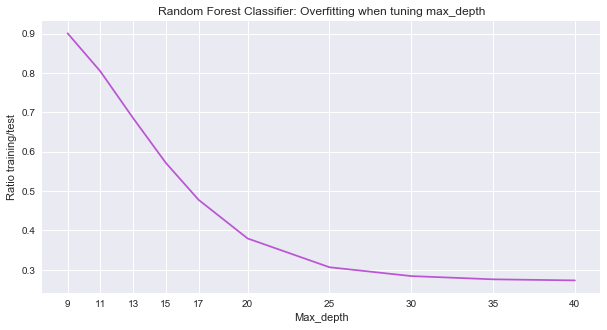

In [181]:
# plot overfitting from log loss scores on training and test sets for max_depth

# Set up data for the plot
avg_log_loss_per_depth_test = np.mean(all_log_losses_test_d, axis=0)
avg_log_loss_per_depth_train = np.mean(all_log_losses_train_d, axis=0)
ratios_log_loss_depth = avg_log_loss_per_depth_train/avg_log_loss_per_depth_test


# Plot max_depth overfitting results
plt.figure(figsize=(10,5), facecolor="white")
x = depth_values 
plt.xticks(x)
plt.xlabel("Max_depth")
plt.ylabel("Ratio training/test")
plt.title("Random Forest Classifier: Overfitting when tuning max_depth")
plt.plot(depth_values, ratios_log_loss_depth, c="mediumorchid")
plt.show()
# plt.savefig("Images/<filename>.png")


**Results - `max_depth`**   

Results with 3-fold cross-validation and 2 iterations:  Use `max_depth=25`

The R-squared score on the test data reaches its optimal value by `max_depth=17` and increases by minimally with higher `max_depth` values.

The mean squared error on the test data reaches its optimal minimum value with `max_depth=17-25` but increases again with higher `max_depth` values.

The overfitting approaches its minimum at `max_depth=25` and does not increase at higher `max_depth` values.


### Test `max_features`

In [19]:
# calculate square root as percentage of dataset
features_sqrt = X.shape[1]**(0.5)
sqrt_percent = features_sqrt/X.shape[1]
sqrt_percent

0.13130643285972257

In [20]:
# calculate square root as percentage of dataset
log2_percent = np.log(X.shape[1])/X.shape[1]
log2_percent

0.070007638112869294

In [163]:
n = 150
num_features = [0.05, 0.07, 0.13, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45]
depth = 25

start = time.time()
all_num_features, \
all_r2_scores_f, \
all_log_losses_train_f,  \
all_log_losses_test_f  = run_max_features_test_CV(X, Y, 
                                                  n_splits, iterations, n, depth, num_features)

#print("Processing time: {} seconds".format((time.time() - start)))
print("Processing time: {} minutes".format(round((time.time() - start)/60, 2)))

Finished iteration 1 and data split 1
Finished iteration 1 and data split 2
Finished iteration 1 and data split 3
Finished iteration 2 and data split 1
Finished iteration 2 and data split 2
Finished iteration 2 and data split 3
Processing time: 64.98 minutes


In [215]:
# save results to CSV
np.savetxt("../Tuning_Results/Classifier/C_features_n150_d25.csv", all_num_features, delimiter=",")
np.savetxt("../Tuning_Results/Classifier/C_features_r2_n150_d25.csv", all_r2_scores_f, delimiter=",")
np.savetxt("../Tuning_Results/Classifier/C_features_loglosstrain_n150_d25.csv", all_log_losses_train_f, delimiter=",")
np.savetxt("../Tuning_Results/Classifier/C_features_loglosstest_n150_d25.csv", all_log_losses_test_f, delimiter=",")

In [217]:
# load results from CSV files (for drawing plots without re-doing tuning calculations above)
all_num_features = np.loadtxt("../Tuning_Results/Classifier/C_features_n150_d25.csv", delimiter=",")
all_r2_scores_f = np.loadtxt("../Tuning_Results/Classifier/C_features_r2_n150_d25.csv", delimiter=",")
all_log_losses_train_f = np.loadtxt("../Tuning_Results/Classifier/C_features_loglosstrain_n150_d25.csv", delimiter=",")
all_log_losses_test_f = np.loadtxt("../Tuning_Results/Classifier/C_features_loglosstest_n150_d25.csv", delimiter=",")
depth_values = all_num_features[0]

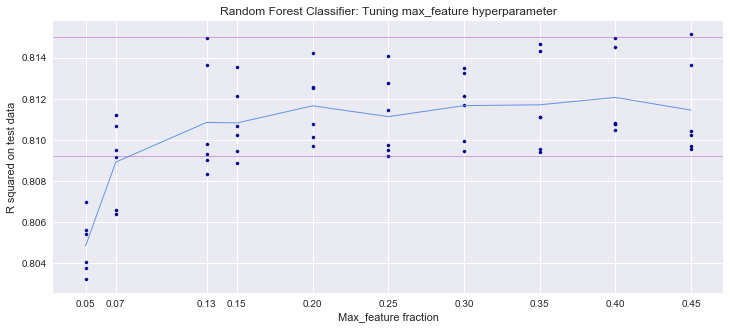

In [193]:
# Plot R squared results from max features on training data

# Set up data for the plot
avg_r2_score_per_feature = np.mean(all_r2_scores_f, axis=0)


# Plot max_depth results
plt.figure(figsize=(12,5))
x = num_features 
plt.xticks(x)
plt.xlabel("Max_feature fraction")
plt.ylabel("R squared on test data")
plt.title("Random Forest Classifier: Tuning max_feature hyperparameter")
plt.plot(num_features, avg_r2_score_per_feature, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_num_features, all_r2_scores_f, c = "darkblue", s=10)
# Lines for best scores 
plt.axhline(y=0.815, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=0.8092, linewidth=0.5, color = 'mediumorchid')
plt.show()
# plt.savefig("Images/<filename>.png")

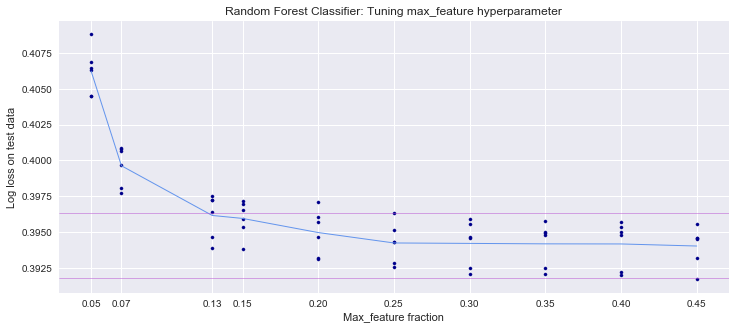

In [199]:
# Plot log loss results on training data

# Set up data for the plot
avg_log_loss_per_feature = np.mean(all_log_losses_test_f, axis=0)

# Plot max_depth results
plt.figure(figsize=(12,5))
x = num_features 
plt.xticks(x)
plt.xlabel("Max_feature fraction")
plt.ylabel("Log loss on test data")
plt.title("Random Forest Classifier: Tuning max_feature hyperparameter")
plt.plot(num_features, avg_log_loss_per_feature, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_num_features, all_log_losses_test_f, c = "darkblue", s=10)
# Lines for best scores 
plt.axhline(y=.3963, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=.3918, linewidth=0.5, color = 'mediumorchid')
plt.show()
# plt.savefig("Images/<filename>.png")

In [221]:
print(avg_log_loss_per_feature_test)

[ 0.40624075  0.39963284  0.39615982  0.39595346  0.39496628  0.39423894
  0.39420796  0.39417719  0.39416985  0.39402533]


In [222]:
print(avg_log_loss_per_feature_train)

[ 0.1300667   0.12369043  0.12135589  0.12158841  0.1207761   0.1207153
  0.1209884   0.12117849  0.12148663  0.12144661]


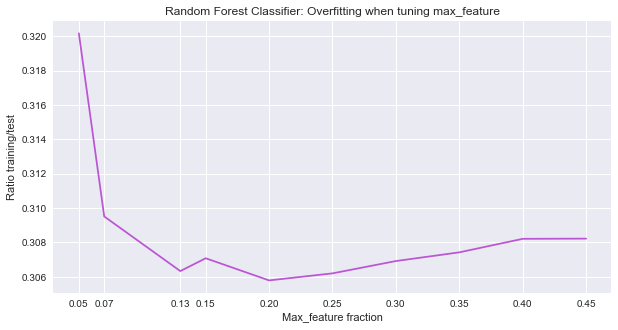

In [168]:
# plot overfitting from log loss scores on training and test sets for max_depth

# Set up data for the plot
avg_log_loss_per_feature_test = np.mean(all_log_losses_test_f, axis=0)
avg_log_loss_per_feature_train = np.mean(all_log_losses_train_f, axis=0)
ratios_log_loss_features = avg_log_loss_per_feature_train/avg_log_loss_per_feature_test


# Plot max_depth overfitting results
plt.figure(figsize=(10,5), facecolor="white")
x = num_features 
plt.xticks(x)
plt.xlabel("Max_feature fraction")
plt.ylabel("Ratio training/test")
plt.title("Random Forest Classifier: Overfitting when tuning max_feature")
plt.plot(num_features, ratios_log_loss_features, c="mediumorchid")
plt.show()
# plt.savefig("Images/<filename>.png")

**Results - `max_features`**   

Results with 3-fold cross-validation and 2 iterations:  Use `max_features=0.25`

The R-squared score on the test data reaches its maximum values by `max_features=0.20` and does not change significantly with higher `max_features` values.

The mean squared error on the test data reaches its minimum value by `max_features=0.25` and does not change significantly with higher `max_features` values.

The overfitting reaches its minimum at `max_features=0.20` and `max_features=0.25`, and begins to increase slightly with higher values of `max_features`.

### Test `n-estimators`

In [170]:
# test n_estimators with CV
n_values = [50, 100, 150, 200, 250, 300, 350]
features = 0.25
depth = 25
start = time.time()
all_n_values, \
all_r2_scores_n,  \
all_log_losses_train_n,  \
all_log_losses_test_n = run_n_estimators_test_CV(X, Y, n_splits, iterations, n_values, depth, features)
#print("Processing time: {} seconds".format((time.time() - start)))
print("Processing time: {} minutes".format(round((time.time() - start)/60, 2)))

Finished iteration 1 and data split 1
Finished iteration 1 and data split 2
Finished iteration 1 and data split 3
Finished iteration 2 and data split 1
Finished iteration 2 and data split 2
Finished iteration 2 and data split 3
Processing time: 62.87 minutes


In [224]:
# save results to CSV
np.savetxt("../Tuning_Results/Classifier/C_n_f25_d25.csv", all_n_values, delimiter=",")
np.savetxt("../Tuning_Results/Classifier/C_n_r2_f25_d25.csv", all_r2_scores_n, delimiter=",")
np.savetxt("../Tuning_Results/Classifier/C_n_loglosstrain_f25_d25.csv", all_log_losses_train_n, delimiter=",")
np.savetxt("../Tuning_Results/Classifier/C_n_loglosstest_f35_d25.csv", all_log_losses_test_n, delimiter=",")

In [231]:
# load results from CSV files (for drawing plots without re-doing tuning calculations above)
all_n_values = np.loadtxt("../Tuning_Results/Classifier/C_n_f25_d25.csv", delimiter=",")
all_r2_scores_n = np.loadtxt("../Tuning_Results/Classifier/C_n_r2_f25_d25.csv", delimiter=",")
all_log_losses_train_n = np.loadtxt("../Tuning_Results/Classifier/C_n_loglosstrain_f25_d25.csv", delimiter=",")
all_log_losses_test_n = np.loadtxt("../Tuning_Results/Classifier/C_n_loglosstest_f35_d25.csv", delimiter=",")
n_values = all_n_values[0]

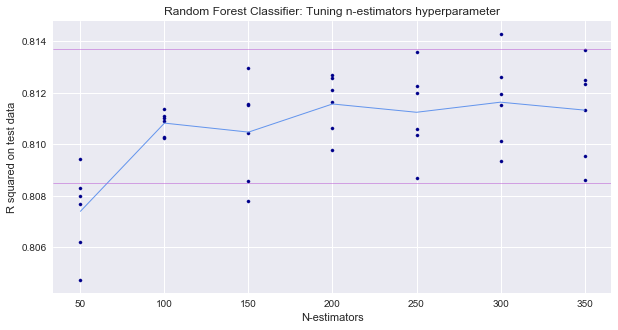

In [201]:
# Plot R squared results from max features on training data

# Set up data for the plot
avg_r2_score_per_n = np.mean(all_r2_scores_n, axis=0)


# Plot max_depth results
plt.figure(figsize=(10,5))
x = n_values 
plt.xticks(x)
plt.xlabel("N-estimators")
plt.ylabel("R squared on test data")
plt.title("Random Forest Classifier: Tuning n-estimators hyperparameter")
plt.plot(n_values, avg_r2_score_per_n, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_n_values, all_r2_scores_n, c = "darkblue", s=10)
# Lines for best scores 
plt.axhline(y=0.8137, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=0.8085, linewidth=0.5, color = 'mediumorchid')
plt.show()
# plt.savefig("Images/<filename>.png")

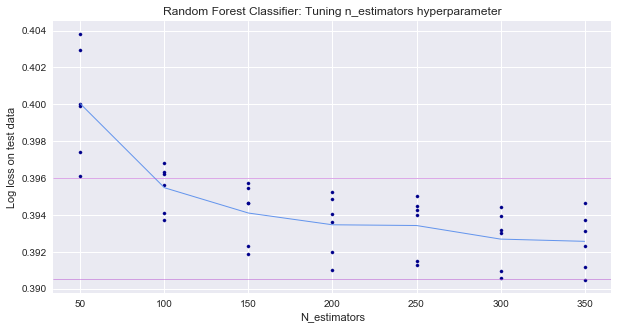

In [206]:
# Plot log loss results on training data

# Set up data for the plot
avg_log_loss_per_n = np.mean(all_log_losses_test_n, axis=0)

# Plot max_depth results
plt.figure(figsize=(10,5))
x = n_values 
plt.xticks(x)
plt.xlabel("N_estimators")
plt.ylabel("Log loss on test data")
plt.title("Random Forest Classifier: Tuning n_estimators hyperparameter")
plt.plot(n_values, avg_log_loss_per_n, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_n_values, all_log_losses_test_n, c = "darkblue", s=10)
# Lines for best scores 
plt.axhline(y=.396, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=0.3905, linewidth=0.5, color = 'mediumorchid')
plt.show()
# plt.savefig("Images/<filename>.png")

In [235]:
print(avg_log_loss_score_per_n_test)

[ 0.40002413  0.39547202  0.39409903  0.39346234  0.39342264  0.39268518
  0.39256413]


In [236]:
print(avg_log_loss_score_per_n_train)

[ 0.12166055  0.12132083  0.12106566  0.12092266  0.12077024  0.12048787
  0.12055369]


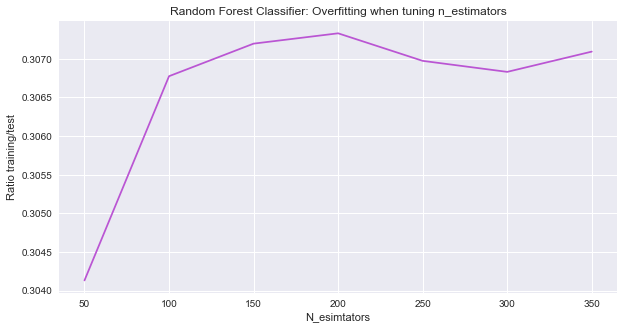

In [175]:
# plot overfitting from log loss scores on training and test sets for max_depth

# Set up data for the plot
avg_log_loss_score_per_n_test = np.mean(all_log_losses_test_n, axis=0)
avg_log_loss_score_per_n_train = np.mean(all_log_losses_train_n, axis=0)
ratios_log_loss_n = avg_log_loss_score_per_n_train/avg_log_loss_score_per_n_test


# Plot max_depth overfitting results
plt.figure(figsize=(10,5), facecolor="white")
x = n_values 
plt.xticks(x)
plt.xlabel("N_esimtators")
plt.ylabel("Ratio training/test")
plt.title("Random Forest Classifier: Overfitting when tuning n_estimators")
plt.plot(n_values, ratios_log_loss_n, c="mediumorchid")
plt.show()
# plt.savefig("Images/<filename>.png")

**Results - `n_estimators`**   

Results with 3-fold cross-validation and 2 iterations:  Use `n_estimators=150`

The R-squared score on the test data approahces its optimal value at `n_estimators=100` and continues to incrementally improve with higher values of `n_estimators`.

The mean squared error on the test data approaches its optimal value at `n_estimators=150` and continues to incrementally improve with higher values of `n_estimators`.

The overfitting appears at first to be increasing as the model improves (instead of initially decreasing or stabilizing as with other hyperparameters.  However, the change in ratio between train and test data log loss with each value of  `n_estimators` is very small (less than 1/2% change) relative the same ratio when testing other hyperparameters (1.5% to 40%, so instead this indicates that there is minimal chage in overfitting between different values of `n_estimators`.

Given the increased computational cost of larger values of `n_estimators` and that increases in model improvement becomes smaller over `n_estimators=150`, we'll use  `n_estimators=150` for this classifier model.

## TESTING on Sample Datasets
Testing implementation with single sample size training/test set before setting up cross-validation.

Helper functions were indepedent of cross-validation functions when running this testing.

In [ ]:
# create single test/training set from sample dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_sample, Y_sample, 
                                                    test_size=0.2, random_state=None, shuffle=True)

In [ ]:
# test max_depth function
n = 50
features = 'sqrt'
depth_values = [15, 30]
start = time.time()
r2_scores_train, r2_scores_test, MSEs_train, MSEs_test = find_max_depth(X_train, Y_train, X_test, Y_test, 
                                                            n, depth_values, features)
print("Processing time: {} seconds".format((time.time() - start)))
#print("Processing time: {} minutes".format(round((time.time() - start)/60, 2)))

In [ ]:
print(r2_scores_train)
print(r2_scores_test)
print(MSEs_train)
print(MSEs_test)

In [ ]:
# calculate square root as percentage of dataset
features_sqrt = X_train.shape[1]**(0.5)
sqrt_percent = features_sqrt/X_train.shape[1]
sqrt_percent

In [ ]:
# calculate square root as percentage of dataset
log2_percent = np.log(X_train.shape[1])/X_train.shape[1]
log2_percent

In [ ]:
# test max_feature function
n = 10
num_features = [.10, .20]
#num_features = [0.05, 'log2'.10, 'sqrt', .15, .20, .40, .60, .80, None]
depth = 10
start = time.time()
r2_scores_train, r2_scores_test, MSEs_train, MSEs_test = find_max_features(X_train, Y_train, X_test, Y_test, 
                                                                           n, depth, num_features)
print("Processing time: {} seconds".format((time.time() - start)))
#print("Processing time: {} minutes".format(round((time.time() - start)/60, 2)))

In [ ]:
print(r2_scores_train)
print(r2_scores_test)
print(MSEs_train)
print(MSEs_test)

In [ ]:
# test n-estimators function
n_values = [10, 20]
features = 0.10
depth = 10
start = time.time()
r2_scores_train, r2_scores_test, MSEs_train, MSEs_test = find_n(X_train, Y_train, X_test, Y_test, 
                                                                n_values, depth, features)
print("Processing time: {} seconds".format((time.time() - start)))
#print("Processing time: {} minutes".format(round((time.time() - start)/60, 2)))

In [ ]:
print(r2_scores_train)
print(r2_scores_test)
print(MSEs_train)
print(MSEs_test)